In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [8]:
def main():
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()

In [9]:
from planning_utils import a_star

In [10]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [11]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-1.22397451e+02  3.77924801e+01  5.60000000e-02], local position [ 0.01777346 -0.04626953 -0.05665046]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.7924801 -122.3974505 0.056
gh:  [-122.39745   37.79248    0.     ]
gp:  [-1.22397451e+02  3.77924801e+01  5.60000000e-02]
lp: [ 0.01081125 -0.0440942  -0.056     ]
gsf:  316.0108112539165 444.95590580487624
gs:  (316, 445)
change [ 0.05959745 -0.35311943  0.46430686]
goal:  (-122.39685452549958, 37.78894890572894, 4.699068641653839)
lg:  [-391.43568474   54.95606956   -4.69906864]
ggf:  -75.43568473914638 499.956069562817
500 920
gg:  (0, 500) 0.0
gg:  (0, 500)
Local Start and Goal:  (316, 445) (0, 500)


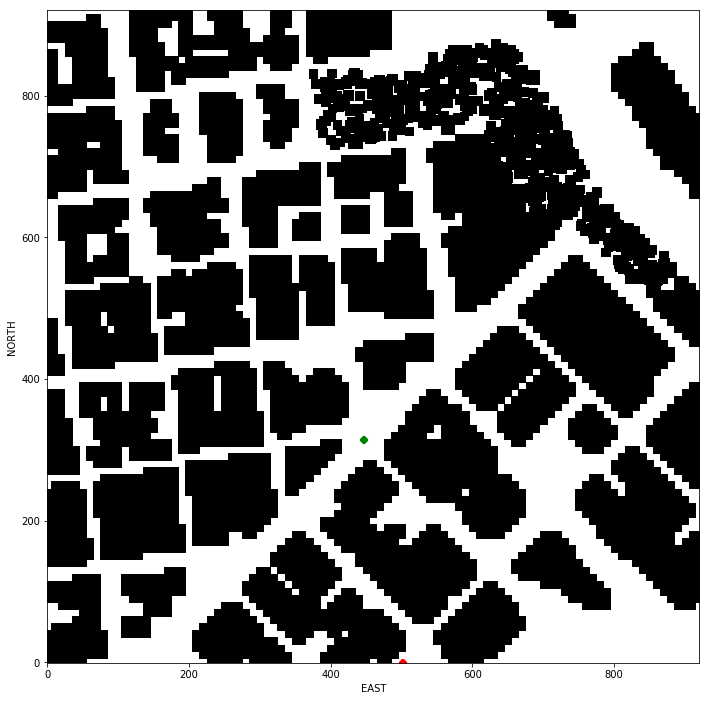

1000 7832 36.35533905932738 327.9029338015924 (290, 470)
2000 15597 71.05382386916231 335.20718841332257 (264, 491)
3000 23382 114.19595949289322 339.37588755043566 (225, 491)
4000 31183 134.09545442950494 342.7099313959897 (208, 484)
5000 38998 55.911688245431385 345.5770123696696 (275, 409)
6000 46807 39.59797974644666 348.77915640505245 (308, 473)
7000 54555 126.13708498984744 352.52171344328286 (225, 525)
8000 62275 22.62741699796953 356.2694407299928 (326, 429)
9000 70015 32.5269119345812 361.0889304333724 (327, 468)
10000 77802 26.142135623730958 367.12453986183823 (338, 455)
11000 85601 33.52691193458119 373.82384110086093 (331, 421)
12000 93441 35.355339059327385 377.83015565173025 (333, 420)
13000 101271 268.575685169861 380.24036176904343 (105, 462)
14000 109157 237.8772003600258 382.0576428617743 (132, 442)
15000 116959 309.44574285495 383.9104996194759 (72, 481)
16000 124725 299.64675298172654 386.00067588045766 (76, 459)
17000 132358 180.36248173426404 388.4874441967231 (1

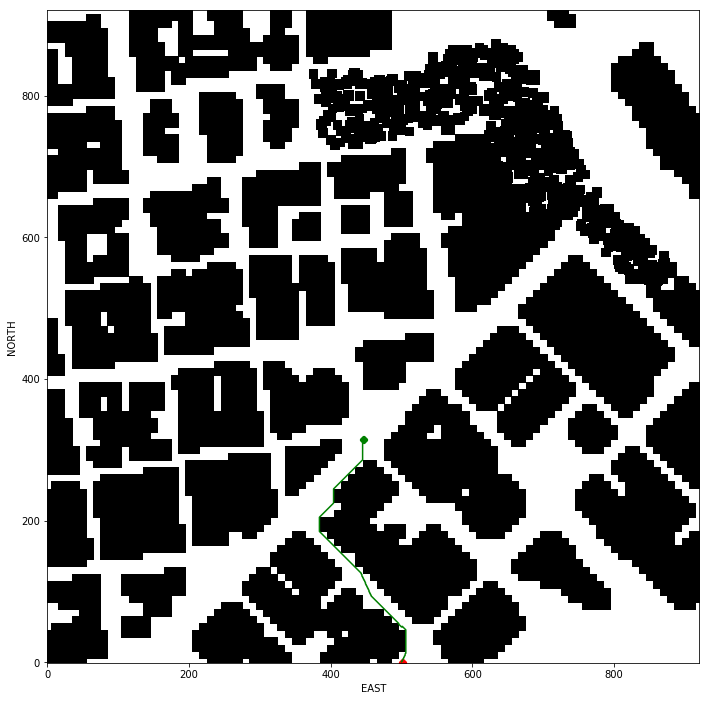

53


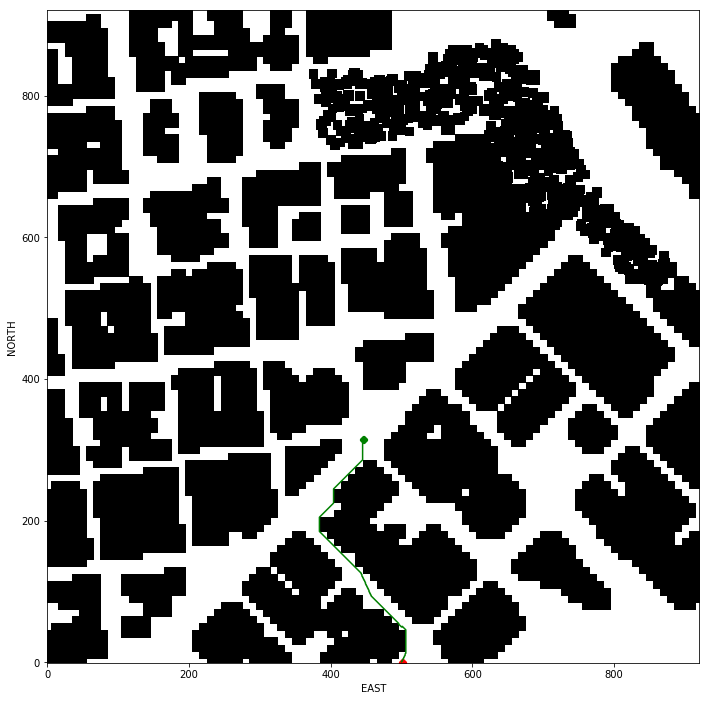

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [-30, 0, 5, 0]
waypoint transition
target position [-71, -41, 5, 0]
waypoint transition
target position [-91, -41, 5, 0]
waypoint transition
target position [-111, -61, 5, 0]
waypoint transition
target position [-131, -61, 5, 0]
waypoint transition
target position [-190, -2, 5, 0]
waypoint transition
target position [-191, -2, 5, 0]
waypoint transition
target position [-192, -1, 5, 0]
waypoint transition
target position [-194, -1, 5, 0]
waypoint transition
target position [-195, 0, 5, 0]
waypoint transition
target position [-196, 0, 5, 0]
waypoint transition
target position [-197, 1, 5, 0]
waypoint transition
target position [-198, 1, 5, 0]
waypoint transition
target position [-199, 2, 5, 0]
waypoint transition
target position [-200, 2, 5, 0]
waypoint transition
target position [-201, 3, 5, 0]
waypoint transition
target position [-202, 3, 5, 0]
wayp

In [12]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    voxmap = create_voxmap(data, 1)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    self.set_home_position(lat0, lon0, 0)
    print((lon0, lat0), " vs ", (-north_offset, -east_offset))    
    print("lla: ",self._latitude, self._longitude, self._altitude)
    print("gh: ",self.global_home)
    print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))
    #3d
    #grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])))
    #2d
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("gs: ",grid_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    grid_shape = grid.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * 10.0)
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #3d
        #grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))
        #2d
        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        print(grid_goal[1], grid_shape[1] - 1)
        if grid_goal[0] >= grid_shape[0]:
            grid_goal = (grid_shape[0] - 1, grid_goal[1])
        elif grid_goal[0] < 0:
            grid_goal = (0, grid_goal[1])            
        if grid_goal[1] >= grid_shape[1]:
            grid_goal = (grid_goal[0], grid_shape[1] - 1)
        elif grid_goal[1] < 0:
            grid_goal = (grid_goal[0], 0)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        print("gg: ",grid_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    print("gg: ",grid_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Local Start and Goal: ', grid_start, grid_goal)
    plot(grid, grid_start, grid_goal, goal_list=goal_list)
    #3d
    #path, _ = a_star(voxmap, heuristic, grid_start, grid_goal)
    #2d
    path, _ = a_star(grid, heuristic, grid_start, grid_goal)
    print(len(path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    
    pruned_path = prune_path(path)
    print(len(pruned_path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
        
    #for p in path:
    #    print(p)
        #print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main()

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3968363   37.789641   -77.285    ], local position [-315.4876709    54.84481812   77.36922455]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.789641 -122.3968363 -77.285
gh:  [-122.3974533   37.7924804    0.       ]
gp:  [-122.3968363   37.789641   -77.285    ]
lp: [-314.68022774   56.35630545   77.285     ]
gsf:  1.3197722556069493 501.3563054513652
gs:  (1, 501)
change [0.28687366 0.11327259 0.02865126]
goal:  (-122.39396756335834, 37.79077372594311, -76.99848738874854)
lg:  [-187.37134587  308.13042071   76.99848739]
ggf:  128.62865412561223 753.1304207134526
753 920
gg:  (129, 753) 1.0
change [-0.10999351 -0.30301997 -0.35290119]
goal:  (-122.3979362351282, 37.78661080025353, -80.81401194020333)
lg:  [-651.50391488  -38.32684128   80.81401194]
ggf:  -335.503914875444 406.673158

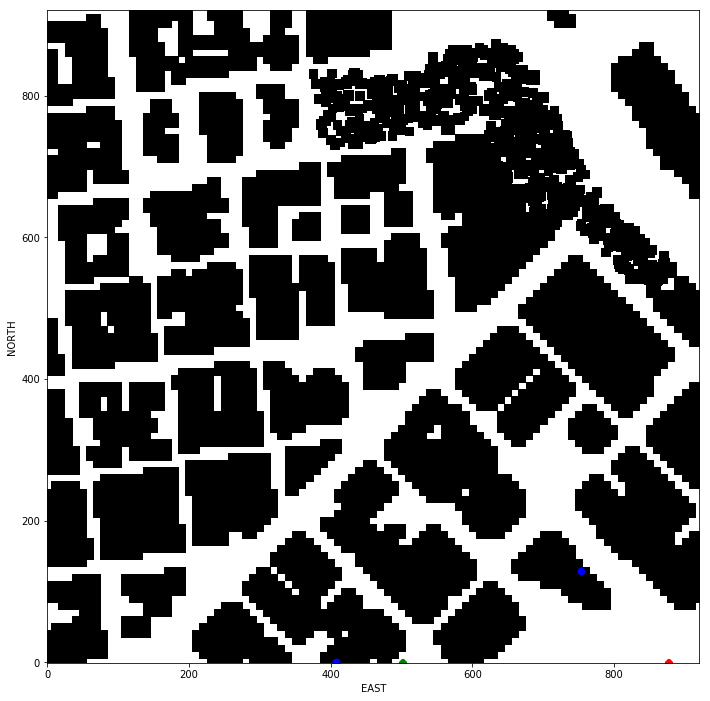

1000 7707 36.45584412271571 382.9771277403313 (19, 530)
2000 15403 48.083261120685215 402.81414503129145 (35, 523)
3000 22993 56.154328932550676 424.44361740018996 (41, 510)
4000 30503 73.53910524340088 450.28570443176784 (53, 503)
5000 38356 205.84776310850265 454.5242597864155 (108, 652)
6000 46271 279.85995641732273 456.7356189602515 (71, 714)
7000 54209 213.91883092036818 458.55120817244006 (111, 658)
8000 62160 324.9726547895311 460.1651102003268 (49, 750)
9000 70138 202.01933598375643 461.6440651603123 (126, 649)
10000 78122 338.0853531617394 463.0373439421988 (27, 754)
11000 86085 319.98484809835116 464.37667612196196 (20, 733)
12000 94034 341.6417023478436 465.6779873615443 (16, 753)
13000 101985 253.3746750430841 466.96540517901485 (105, 690)
14000 109946 368.95541084682844 468.2781172134997 (8, 777)
15000 117886 402.91378028648563 469.64458276929713 (33, 818)
16000 125829 454.78383797157466 470.90835346817175 (8, 862)
Found a path.
376


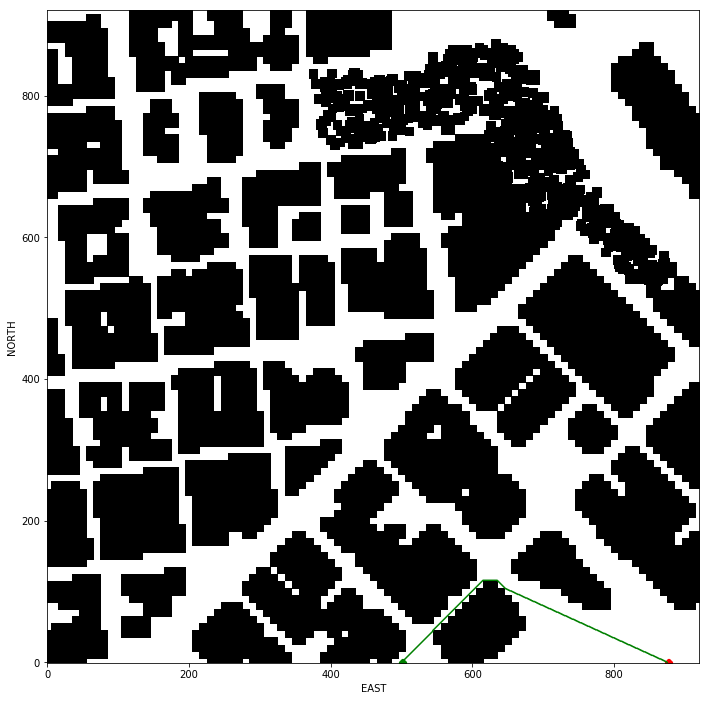

214


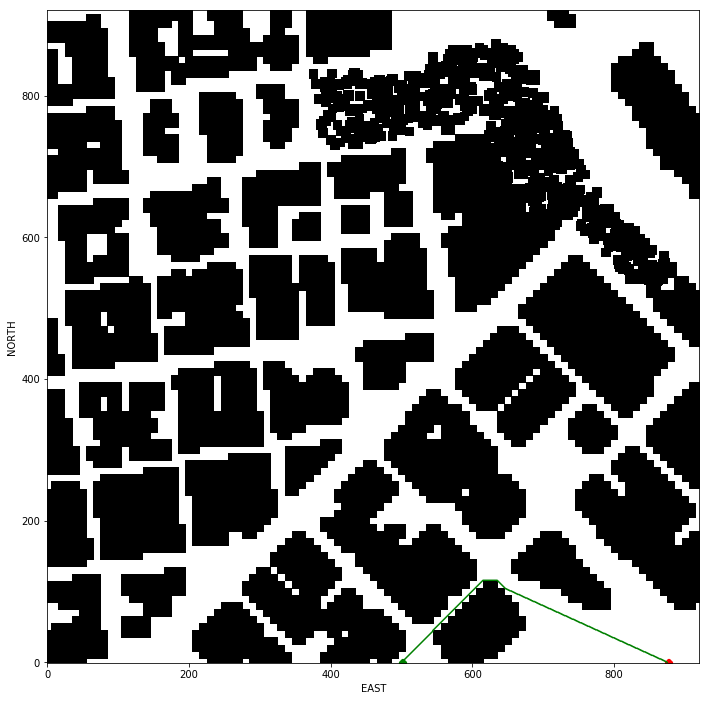

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [-315, 56, 5, 0]
waypoint transition
target position [-272, 99, 5, 0]
waypoint transition
target position [-271, 99, 5, 0]
waypoint transition
target position [-200, 170, 5, 0]
waypoint transition
target position [-200, 190, 5, 0]
waypoint transition
target position [-212, 202, 5, 0]
waypoint transition
target position [-212, 203, 5, 0]
waypoint transition
target position [-213, 204, 5, 0]
waypoint transition
target position [-213, 205, 5, 0]
waypoint transition
target position [-214, 206, 5, 0]
waypoint transition
target position [-214, 207, 5, 0]
waypoint transition
target position [-215, 208, 5, 0]
waypoint transition
target position [-215, 210, 5, 0]
waypoint transition
target position [-216, 211, 5, 0]
waypoint transition
target position [-216, 212, 5, 0]
waypoint transition
target position [-217, 213, 5, 0]
waypoint transition
target position [-217, 214, 5, 0]
waypoint transition
target posi

In [ ]:
main()

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())